7/2/2019

Reuben suggested using a character-based model to make inference easier (there are fewer possible next tokens)
Chris suggested using a bert-tokenizer (so I used the sentencepiece library from some Google people).

The models implemented below are conditional language models that take the entire color context (all three colors) and produce an utterance. 

This notebook contains the code that implements and trains these models. Both are "evaluated" qualitatively

In [1]:
# so we can access classes from parent directory
import sys
sys.path.append("..")

In [10]:
from monroe_data import MonroeData, MonroeDataEntry, Color # for loading in training data
import caption_featurizers                              # for getting caption representations
import color_featurizers                                # for getting color representations
from experiment import FeatureHandler                   # for combining caption and color features

from models import PytorchModel, LiteralSpeaker, CaptionGenerator # model base that handles training / evaluation

In [67]:
import importlib
importlib.reload(caption_featurizers)
import caption_featurizers

In [3]:
# get data
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [4]:
# define feature functions
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer = caption_featurizers.CharacterTokenizer)

#    use fourier representation from the hsv space and normalize all hsv values to be between 0 and 1
color_phi = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "hsv", normalized=True)

In [5]:
# speaker's target is to predict tokens following the SOS token
def speaker_target(data_entry):
    _, caption_ids = caption_phi.to_string_features(data_entry.caption) # this probably works...
    target = caption_ids[1:]
    return target
# pass in train and dev data, our caption and color feature functions, function for turning an element of our data
# (train or dev) into the target, and we only care the target (which is the first color) so we aren't going to mess that up
# by randomizing the order of the colors
# we aren't going to use the dev data to train the model, but we'll still include it in the feature handler
feature_handler = FeatureHandler(train_data, dev_data, caption_phi, color_phi, target_fn=speaker_target, randomized_colors=False)

In [6]:
X_train = feature_handler.train_features()
y_train = feature_handler.train_targets()

In [12]:
model = LiteralSpeaker(CaptionGenerator, optimizer=torch.optim.Adam, lr=0.004, num_epochs=5)
model.init_model(color_in_dim=54, color_dim=100,
                 vocab_size=caption_phi.caption_indexer.size, embed_dim=100,
                 speaker_hidden_dim=100)

In [14]:
model.fit(X_train, y_train)

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0040
0m 7s (0:1000 7.90%) 1.2253
0m 17s (0:2000 15.79%) 1.0327
0m 26s (0:3000 23.69%) 1.1016
0m 37s (0:4000 31.58%) 1.0374
0m 47s (0:5000 39.48%) 1.2268
0m 58s (0:6000 47.37%) 0.9157
1m 8s (0:7000 55.27%) 0.8102
1m 17s (0:8000 63.17%) 0.9745
1m 27s (0:9000 71.06%) 0.7432
1m 36s (0:10000 78.96%) 0.8101
1m 43s (0:11000 86.85%) 0.7606
1m 52s (0:12000 94.75%) 0.7305
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.0609199364880721
---EPOCH 1---
2m 4s (1:0 0.00%) 0.0007
2m 12s (1:1000 7.90%) 0.7569
2m 23s (1:2000 15.79%) 0.8854
2m 33s (1:3000 23.69%) 0.9835
2m 45s (1:4000 31.58%) 0.9493
2m 55s (1:5000 39.48%) 1.1218
3m 4s (1:6000 47.37%) 0.8471
3m 13s (1:7000 55.27%) 0.7426
3m 22s (1:8000 63.17%) 0.9110
3m 32s (1:9000 71.06%) 0.7098
3m 41s (1:10000 78.96%) 0.7733
3m 50s (1:11000 86.85%) 0.7116
3m 58s (1:12000 94.75%) 0.6977
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 0.9792641280281047
---EPOCH 2---
4m 12s (2:0 0.00%) 0.0008
4m 20s (2:1000 7.90%) 0.7118
4m 29s

In [15]:
model.save_model("../model/character_literal_speaker_full_context.params")

In [89]:
X_assess = feature_handler.test_features()

In [68]:
# now let's try with the subword modeling:
caption_phi_subword = caption_featurizers.CaptionFeaturizer(tokenizer = caption_featurizers.SentencePieceTokenizer)
def speaker_target_subword(data_entry):
    _, caption_ids = caption_phi_subword.to_string_features(data_entry.caption) # this probably works...
    target = caption_ids[1:]
    return target


feature_handler_subword = FeatureHandler(train_data, dev_data, caption_phi_subword, color_phi, target_fn=speaker_target_subword, randomized_colors=False)

In [69]:
X_train_subword = feature_handler_subword.train_features()
y_train_subword = feature_handler_subword.train_targets()

In [56]:
model_subword = LiteralSpeaker(CaptionGenerator, optimizer=torch.optim.Adam, lr=0.004, num_epochs=5)
model_subword.init_model(color_in_dim=54, color_dim=100,
                 vocab_size=caption_phi_subword.caption_indexer.size, embed_dim=100,
                 speaker_hidden_dim=100)

In [57]:
model_subword.fit(X_train_subword, y_train_subword)

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0047
0m 5s (0:1000 7.90%) 2.3788
0m 10s (0:2000 15.79%) 2.1848
0m 17s (0:3000 23.69%) 2.1840
0m 23s (0:4000 31.58%) 2.0452
0m 29s (0:5000 39.48%) 2.1693
0m 35s (0:6000 47.37%) 1.8951
0m 40s (0:7000 55.27%) 1.7579
0m 46s (0:8000 63.17%) 1.9497
0m 51s (0:9000 71.06%) 1.6707
0m 57s (0:10000 78.96%) 1.7363
1m 1s (0:11000 86.85%) 1.6079
1m 7s (0:12000 94.75%) 1.5733
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 2.0135171137452126
---EPOCH 1---
1m 13s (1:0 0.00%) 0.0023
1m 19s (1:1000 7.90%) 1.5591
1m 25s (1:2000 15.79%) 1.8546
1m 31s (1:3000 23.69%) 1.9572
1m 38s (1:4000 31.58%) 1.8781
1m 44s (1:5000 39.48%) 2.0364
1m 50s (1:6000 47.37%) 1.7689
1m 55s (1:7000 55.27%) 1.6444
2m 1s (1:8000 63.17%) 1.8493
2m 7s (1:9000 71.06%) 1.6007
2m 12s (1:10000 78.96%) 1.6542
2m 17s (1:11000 86.85%) 1.5157
2m 23s (1:12000 94.75%) 1.5057
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.947226592173179
---EPOCH 2---
2m 30s (2:0 0.00%) 0.0019
2m 37s (2:1000 7.90%) 1.4965
2m 44s (

In [58]:
model_subword.save_model("../model/subword100_literal_speaker_full_context.params")

In [60]:
X_assess_subword = feature_handler_subword.test_features()
y_assess_subword = feature_handler_subword.test_targets()

In [80]:
pred_subword = model_subword.predict(X_assess_subword[:50])

0) Game: 2641-2 Round: 1
gray


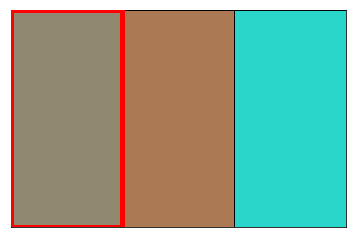

1) Game: 2641-2 Round: 2
green


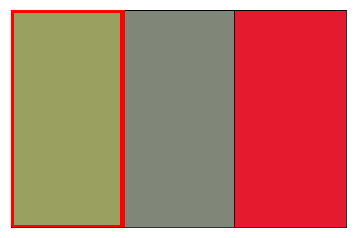

2) Game: 2641-2 Round: 3
lavender ~ the duller one


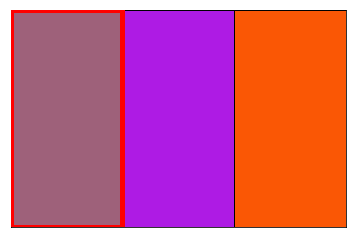

3) Game: 2641-2 Round: 4
the brighter blue


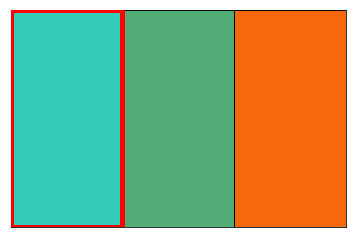

4) Game: 2641-2 Round: 5
yellow


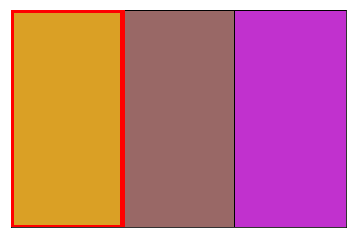

5) Game: 2641-2 Round: 6
the dullest purple


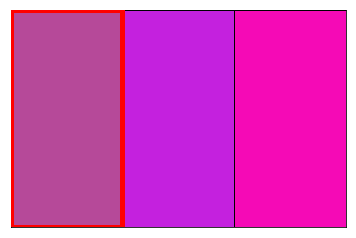

6) Game: 2641-2 Round: 7
green


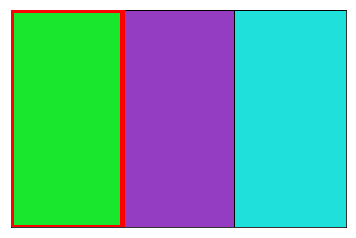

7) Game: 2641-2 Round: 8
green


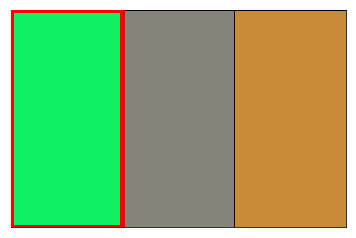

8) Game: 2641-2 Round: 9
the brightest one


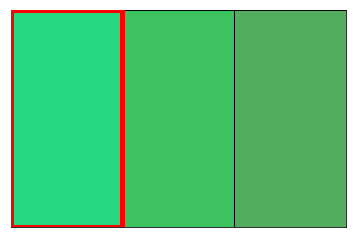

9) Game: 2641-2 Round: 10
green


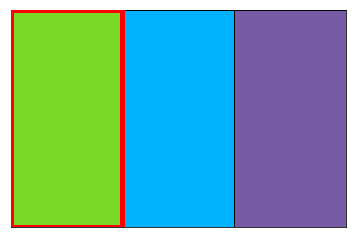

10) Game: 2641-2 Round: 11
dull lavender


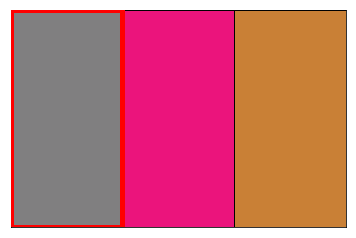

11) Game: 2641-2 Round: 12
the duller aqua


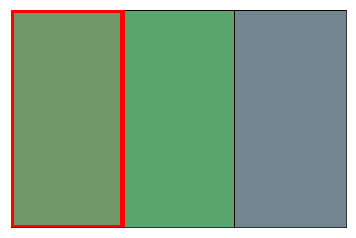

12) Game: 2641-2 Round: 13
the more grey green


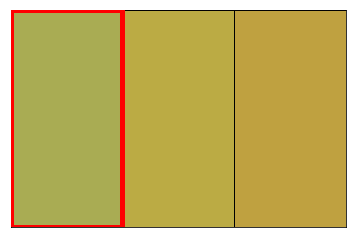

13) Game: 2641-2 Round: 14
yellow


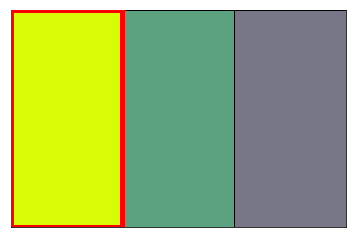

14) Game: 2641-2 Round: 15
the slightly darker lavender


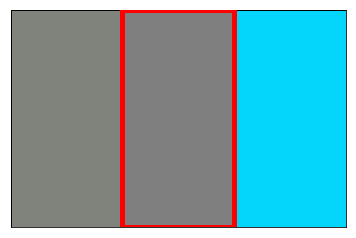

15) Game: 2641-2 Round: 16
the duller purple ~ dullest ~ more purple


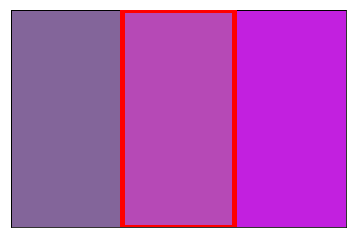

16) Game: 2641-2 Round: 17
blue


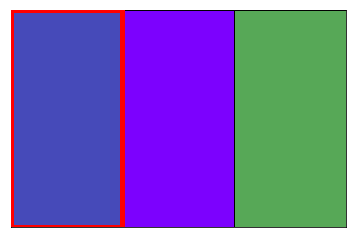

17) Game: 2641-2 Round: 18
red


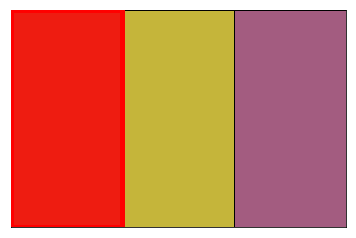

18) Game: 2641-2 Round: 19
the brighter green


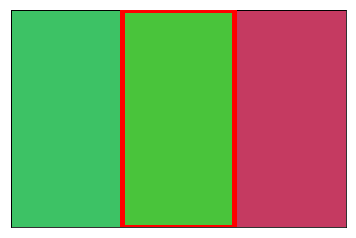

19) Game: 2641-2 Round: 20
orange


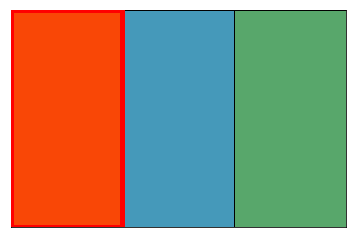

20) Game: 2641-2 Round: 21
the purplish blue


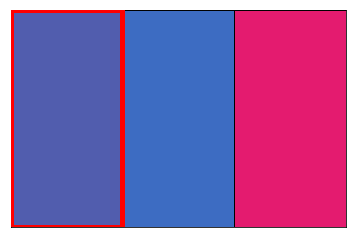

21) Game: 2641-2 Round: 22
lavender


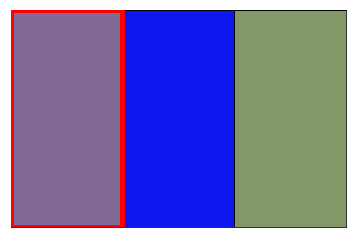

22) Game: 2641-2 Round: 23
blue


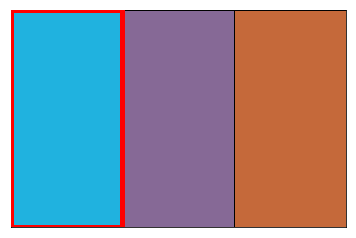

23) Game: 2641-2 Round: 24
pink


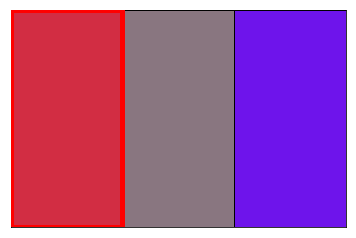

24) Game: 2641-2 Round: 25
the lightest lavender


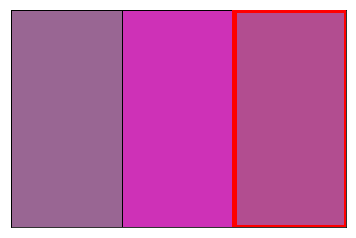

25) Game: 2641-2 Round: 26
the one that looks more yellow, but not greyed out


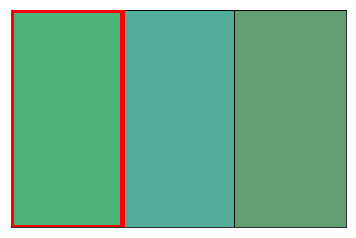

26) Game: 2641-2 Round: 27
the most intense blue


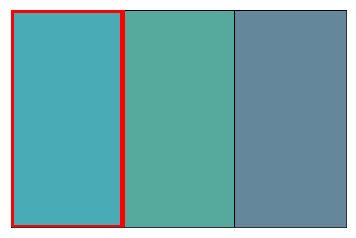

27) Game: 2641-2 Round: 28
the most bright and neon looking


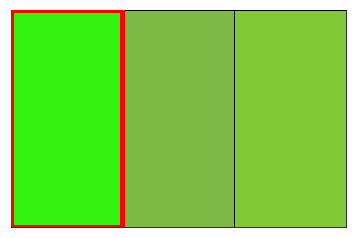

28) Game: 2641-2 Round: 29
the dull lavender that is more purplish


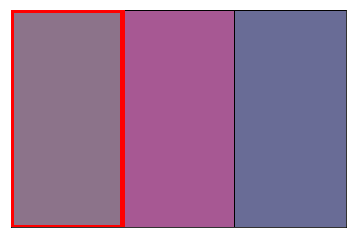

29) Game: 2641-2 Round: 30
the greyish blue that is slightly darker? hard to see ~ the more grey one


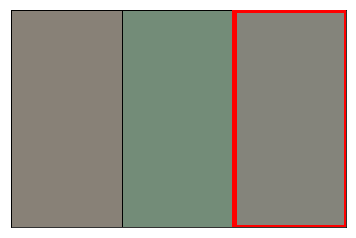

30) Game: 2641-2 Round: 31
the brightest one


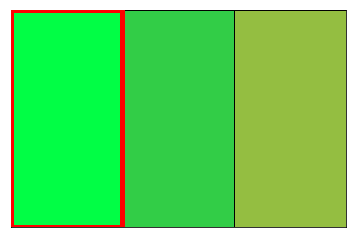

31) Game: 2641-2 Round: 32
the yellowest one


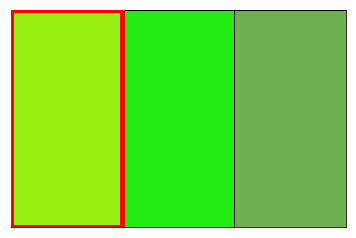

32) Game: 2641-2 Round: 33
green


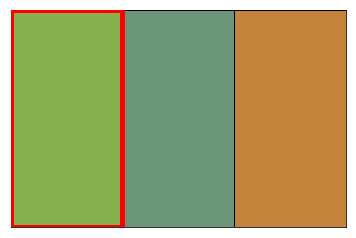

33) Game: 2641-2 Round: 34
brown/orange


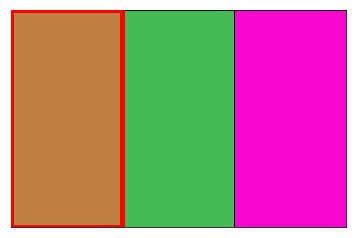

34) Game: 2641-2 Round: 35
blue


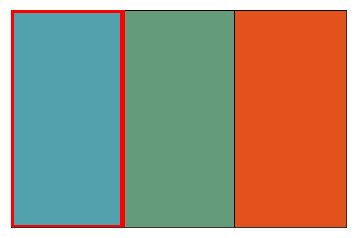

35) Game: 2641-2 Round: 36
the most intense one


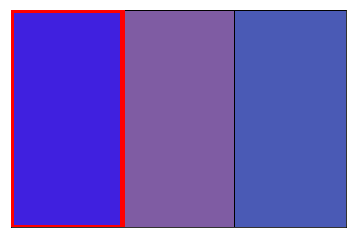

36) Game: 2641-2 Round: 37
the dull slightly bluish lavender


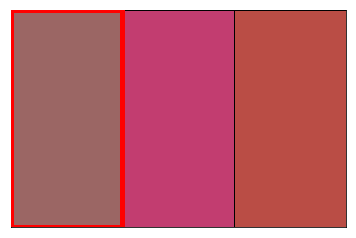

37) Game: 2641-2 Round: 38
grey


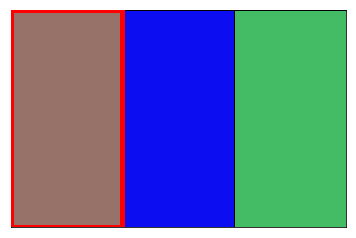

38) Game: 2641-2 Round: 39
bright blue green ~ the lighter one


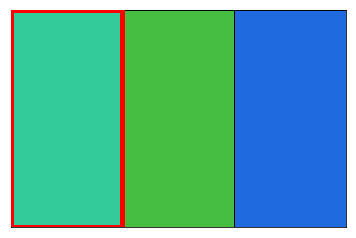

39) Game: 2641-2 Round: 40
the greyest one


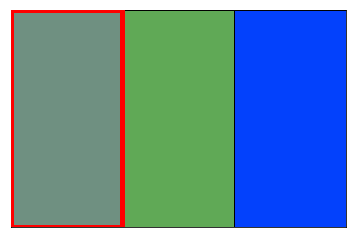

40) Game: 2641-2 Round: 41
the lighter blue


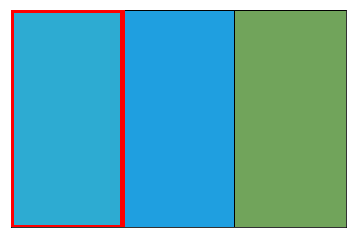

41) Game: 2641-2 Round: 42
pink


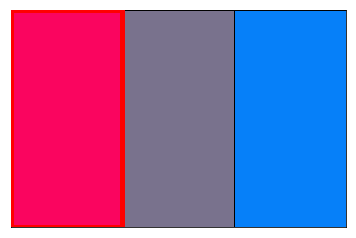

42) Game: 2641-2 Round: 43
the most intense one


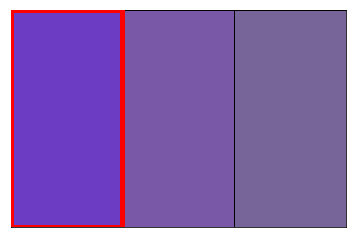

43) Game: 2641-2 Round: 44
red


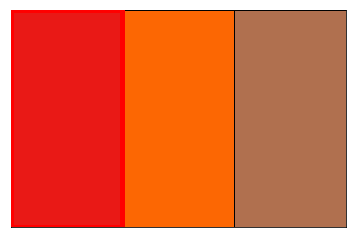

44) Game: 2641-2 Round: 45
the greyish blue


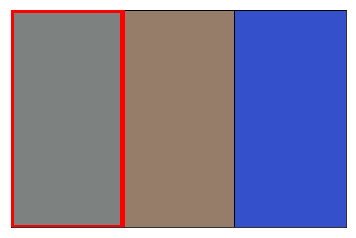

45) Game: 2641-2 Round: 46
blue


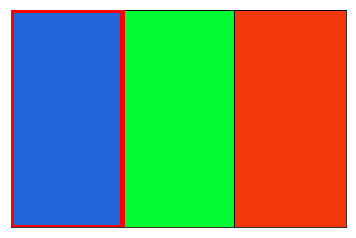

46) Game: 2641-2 Round: 47
the yellower green


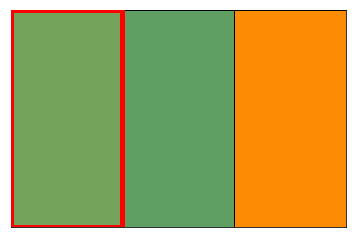

47) Game: 2641-2 Round: 48
the brighter lavender


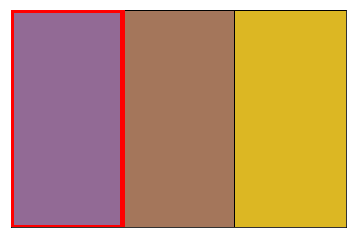

48) Game: 2641-2 Round: 49
the pinker pink


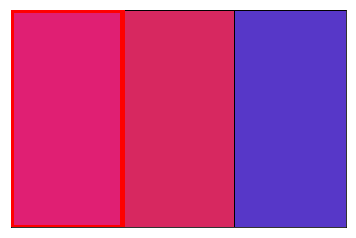

49) Game: 2641-2 Round: 50
the bluer grey


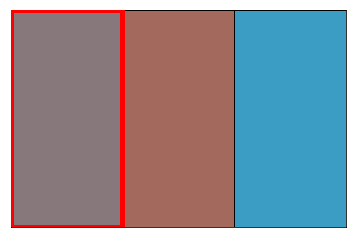

In [81]:
dev_data.display_game_for_gameid('2641-2')

In [87]:
def subwordify(tokens):
    word_tokens = [caption_phi_subword.caption_indexer.get_word_from_idx(t) for t in tokens]
    return caption_phi_subword.tokenizer.untokenize(word_tokens)

def wordify(tokens):
    chars = [caption_phi.caption_indexer.get_word_from_idx(t) for t in tokens]
    return "".join(chars)

In [85]:
for i, pred in enumerate(pred_subword):
    print(f"{i})", subwordify(pred[0]))

0) <sos>▁grey<eos>
1) <sos>▁green<eos>
2) <sos>▁purple<eos>
3) <sos>▁blue<eos>
4) <sos>▁orange<eos>
5) <sos>▁pink<eos>
6) <sos>▁green<eos>
7) <sos>▁green<eos>
8) <sos>▁green<eos>
9) <sos>▁green<eos>
10) <sos>▁grey<eos>
11) <sos>▁grey<eos>
12) <sos>▁tan<eos>
13) <sos>▁yellow<eos>
14) <sos>▁grey<eos>
15) <sos>▁purple<eos>
16) <sos>▁blue<eos>
17) <sos>▁red<eos>
18) <sos>▁green<eos>
19) <sos>▁red<eos>
20) <sos>▁light▁blue<eos>
21) <sos>▁purple<eos>
22) <sos>▁blue<eos>
23) <sos>▁red<eos>
24) <sos>▁purple<eos>
25) <sos>▁green<eos>
26) <sos>▁blue<eos>
27) <sos>▁bright▁green<eos>
28) <sos>▁grey<eos>
29) <sos>▁grey<eos>
30) <sos>▁bright▁green<eos>
31) <sos>▁yellow<eos>
32) <sos>▁green<eos>
33) <sos>▁orange<eos>
34) <sos>▁blue<eos>
35) <sos>▁blue<eos>
36) <sos>▁purple<eos>
37) <sos>▁brown<eos>
38) <sos>▁green<eos>
39) <sos>▁grey<eos>
40) <sos>▁blue<eos>
41) <sos>▁red<eos>
42) <sos>▁purple<eos>
43) <sos>▁red<eos>
44) <sos>▁grey<eos>
45) <sos>▁blue<eos>
46) <sos>▁green<eos>
47) <sos>▁purple<eos>
4

In [90]:
pred_char = model.predict(X_assess[:50])

In [91]:
for i, pred in enumerate(pred_char):
    print(f"{i})", wordify(pred[0]))

0) <sos>gray<eos>
1) <sos>tan<eos>
2) <sos>orange<eos>
3) <sos>blue<eos>
4) <sos>yellow<eos>
5) <sos>brig
6) <sos>green<eos>
7) <sos>green<eos>
8) <sos>green<eos>
9) <sos>green<eos>
10) <sos>gray<eos>
11) <sos>green<eos>
12) <sos>tan<eos>
13) <sos>yellow<eos>
14) <sos>gray<eos>
15) <sos>purple<eos>
16) <sos>blue<eos>
17) <sos>red<eos>
18) <sos>green<eos>
19) <sos>orange<eos>
20) <sos>purple<eos>
21) <sos>purple<eos>
22) <sos>blue<eos>
23) <sos>red<eos>
24) <sos>purple<eos>
25) <sos>green<eos>
26) <sos>blue<eos>
27) <sos>green<eos>
28) <sos>gray<eos>
29) <sos>gray<eos>
30) <sos>bright green<eos>
31) <sos>yellow<eos>
32) <sos>green<eos>
33) <sos>orange<eos>
34) <sos>blue<eos>
35) <sos>blue<eos>
36) <sos>brown<eos>
37) <sos>brown<eos>
38) <sos>green<eos>
39) <sos>grey<eos>
40) <sos>blue<eos>
41) <sos>red<eos>
42) <sos>purple<eos>
43) <sos>red<eos>
44) <sos>gray<eos>
45) <sos>blue<eos>
46) <sos>green<eos>
47) <sos>purple<eos>
48) <sos>pink<eos>
49) <sos>gray<eos>
